In [1]:
import numpy as np
import torch
import cv2
from vggNet import *
from FCN import *


def vgg(img_folder):
    # specify gpu id
    gpu_id = 0

    model = vgg16(pretrained=True)
    model.eval()
    model.cuda(gpu_id)

    img_path = img_folder
    image = cv2.imread(img_path)
    h, w, ch = image.shape

    # 对图像内容计算
    input1 = image.transpose((2, 0, 1))
    input1 = np.float32(input1) / 255.0
    input1 = np.reshape(input1, [1, ch, h, w])
    input1 = torch.from_numpy(input1)
    input1 = input1.cuda(gpu_id)

    conv_1, conv_2 = model(input1)
    conv_1 = conv_1.data.cpu().numpy()
    conv_2 = conv_2.data.cpu().numpy()
    
    feat1 = np.zeros((h, w))
    feat2 = np.zeros((h, w))
    
    for i in range(h):
        for j in range(w):
            feat1[i, j] = np.mean(conv_1[0, :, i, j])
            feat2[i, j] = np.mean(conv_2[0, :, i, j])
            
    return feat1, feat2


def fcn(img_folder):
    img_path = img_folder
    image = cv2.imread(img_path)
    h, w, ch = image.shape
    n_class = 20
    batch_size = 10

    # 对图像内容计算
    input = image.transpose((2, 0, 1))
    input = np.float32(input) / 255.0
    input = np.reshape(input, [1, ch, h, w])
    input = torch.from_numpy(input)
    # input = input.cuda(gpu_id)

    vgg_model = VGGNet(requires_grad=True)
    fcn_model = FCNs(pretrained_net=vgg_model, n_class=n_class)
    output, output_2, output_3 = fcn_model(input)
    
    out = output.data.numpy()
    out_2 = output_2.data.numpy()
    out_3 = output_3.data.numpy()

    h = h - 1
    w = w - 1
    feat = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            feat[i, j] = np.mean(out[0, :, i, j])
    
    h = out_2.shape[2]
    w = out_2.shape[3]    
    out2 = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            out2[i, j] = np.mean(out_2[0, :, i, j])
      
    h = out_3.shape[2]
    w = out_3.shape[3]    
    out3 = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            out3[i, j] = np.mean(out_3[0, :, i, j])
            
    return feat, out2, out3

(120, 80)
graph success


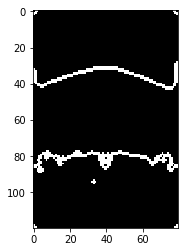

In [3]:
import skimage
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed, mark_boundaries, find_boundaries
from skimage.filters import sobel
from skimage.color import rgb2gray

from os.path import basename, join, isfile
import os
import matplotlib.pyplot as plt    

import torchvision.models as models

from image_segmentation import normal_image_segmentation

% matplotlib inline

basename = os.getcwd()
img_dir = join(basename, 'input')
img_list = [join(img_dir, f) for f in os.listdir(img_dir) if isfile(join(img_dir, f))]

def sp_met(img_path, met='watershed', sp_show=True, feat_show=True):
    
    # VGG feat
    #  get conv feature
#     img = cv2.imread(img_path)
#     conv_1, conv_2 = vgg(img_path)
#     conv_1_2 = (conv_1 + conv_2) / 2

#     gray_img = skimage.io.imread(img_path, as_gray=True)
#     comb = (gray_img + conv_1_2) / 2

#     # FCN 
    #  get conv feature
    feat, out2, out3 = fcn(img_path)
    return out2, out3


#     if feat_show == True:
#         # vis feature
#         fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

#         ax[0, 0].imshow(img)
#         ax[0, 0].set_title('ori-img')

#         ax[0, 1].imshow(conv_1)
#         ax[0, 1].set_title('vgg conv_1 feat')

#         ax[1, 0].imshow(conv_2)
#         ax[1, 0].set_title('vgg conv_2 feat')

#         ax[1, 1].imshow(conv_1_2)
#         ax[1, 1].set_title('vgg conv (1+2) feat')
    
        
#         fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

#         ax[0, 0].imshow(img)
#         ax[0, 0].set_title('ori-img')

#         ax[0, 1].imshow(conv_1, cmap='gray')
#         ax[0, 1].set_title('vgg conv_1 feat')

#         ax[1, 0].imshow(conv_2, cmap='gray')
#         ax[1, 0].set_title('vgg conv_2 feat')

#         ax[1, 1].imshow(conv_1_2, cmap='gray')
#         ax[1, 1].set_title('vgg conv (1+2) feat')
        
        
#         fig, ax = plt.subplots(2, 2, figsize=(10, 10))

#         ax[0, 0].imshow(img)
#         ax[0, 0].set_title('ori-img')

#         ax[0, 1].imshow(feat, cmap='gray')
#         ax[0, 1].set_title('fcn feat')

#         ax[1, 0].imshow(out2, cmap='gray')
#         ax[1, 0].set_title('')

#         ax[1, 1].imshow(out3, cmap='gray')
#         ax[1, 1].set_title('')
        
#         plt.show()
        
#     # generate superpixels
#     if met == 'felzenszwalb':
#         # 1. use rgb
#         segments_rgb = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
#         # 2. use vgg16 conv_1, conv_2, conv_1_2
#         segments_conv_1 = felzenszwalb(conv_1, scale=100, sigma=0.5, min_size=50)
#         segments_conv_2 = felzenszwalb(conv_2, scale=100, sigma=0.5, min_size=50)
#         segments_conv_1_2 = felzenszwalb(conv_1_2, scale=100, sigma=0.5, min_size=50)
#         # 3. combined?
#         segments_comb = felzenszwalb(comb, scale=100, sigma=0.5, min_size=50)

        
#     elif met == 'slic':
#         # 1. use img
#         segments_rgb = slic(img, n_segments=250, compactness=10, sigma=1)
#         # 2. use feat_1, feat_2, feat_1_2
#         segments_conv_1 = slic(conv_1, n_segments=50, compactness=10, sigma=1)
#         segments_conv_2 = slic(conv_2, n_segments=25, compactness=10, sigma=1)
#         segments_conv_1_2 = slic(conv_1_2, n_segments=9, compactness=10, sigma=1)
#         # 3. combined?
#         segments_comb = slic(comb, n_segments=250, compactness=10, sigma=1)

        
#     elif met == 'quickshift':
        
#         # 1. use img
#         segments_rgb = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
#         # 2. use feat_1, feat_2, feat_1_2
#         segments_conv_1 = quickshift(conv_1, kernel_size=3, max_dist=6, ratio=0.5)
#         segments_conv_2 = quickshift(conv_2, kernel_size=3, max_dist=6, ratio=0.5)
#         segments_conv_1_2 = quickshift(conv_1_2, kernel_size=3, max_dist=6, ratio=0.5)
#         # 3. combined?
#         segments_comb = quickshift(comb, kernel_size=3, max_dist=6, ratio=0.5)
        
        
#     elif met == 'watershed':

#         # 1. use img
#         gradient = sobel(rgb2gray(img))
#         segments_rgb = watershed(gradient, markers=250, compactness=0.001)
#         # 2. use feat_1, feat_2, feat_1_2
#         gradient = sobel(conv_1)
#         segments_conv_1 = watershed(gradient, markers=250, compactness=0.001)
        
#         gradient = sobel(conv_2)
#         segments_conv_2 = watershed(gradient, markers=250, compactness=0.001)
        
#         gradient = sobel(conv_1_2)
#         segments_conv_1_2 = watershed(gradient, markers=250, compactness=0.001)
        
#         # 3. combined?
#         gradient = sobel(comb)
#         segments_comb = watershed(gradient, markers=250, compactness=0.001)
        
#     else:
#         print('superpixels method need')
        
#     if sp_show == True:
#         # show superpixels results
#         fig, ax = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

#         # superpixel vis
#         ax[0, 0].imshow(img)
#         ax[0, 0].set_title('ori-img')

#         ax[0, 1].imshow(mark_boundaries(img, segments_conv_1))
#         ax[0, 1].set_title('conv_1_feat')

#         ax[1, 0].imshow(mark_boundaries(img, segments_conv_2))
#         ax[1, 0].set_title('conv_2_feat')

#         ax[1, 1].imshow(mark_boundaries(img, segments_conv_1_2))
#         ax[1, 1].set_title('conv_1_2_feat')

#         ax[2, 0].imshow(mark_boundaries(img, segments_rgb))
#         ax[2, 0].set_title('rgb_feat')

#         ax[2, 1].imshow(mark_boundaries(img, segments_comb))
#         ax[2, 1].set_title('comb_feat')
#         plt.show()

        
# vis part
for img_path in img_list:
    
    if img_path[-3:] == 'jpg':
#         out2, out3 = sp_met(img_path=img_path)
        feat, out2, out3 = fcn(img_path)
#         print(out2.shape)
#         print(out3.shape)
        
#         for k in [2, 5, 8]:
        # add our method
        segments = normal_image_segmentation(m_img=out2, graph_met='syn_met', num_cuts=2)
    #         plt.figure()
    #         plt.imshow(segments)
    #         plt.show()


        # plot segments in different paras
        plt.figure()
        bounder = find_boundaries(segments, mode='thick').astype(np.uint8)
        plt.imshow(bounder, cmap='gray')

    #         plt.figure()
    #         plt.imshow(mark_boundaries(out3, segments))
        plt.show()
        
        
#         # weight of rgb and conv feat 
#         weight = [0.01, 0.1, 1, 10, 100]
#         fig, ax = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

#         for i, w in enumerate(weight):
#             comb = (w * gray_img + conv_1_2) / (w + 1)
#             segments_comb = felzenszwalb(comb, scale=100, sigma=0.5, min_size=50)

#             ax[int(i-i%2)/2, int(i%2)].imshow(mark_boundaries(img, segments_comb))
# #             ax[int(i-i%2)/2, int(i%2)].set_title('Subplot n°{}' .format(i+1))

#         fig.delaxes(ax[2, 1])
#         plt.show()
        


In [3]:
# add our method
m_img = np.asarray([[1,2],[3,4]])
len(m_img.shape)

2

In [ ]:
import skimage
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed, mark_boundaries
from os.path import join, isfile
import os
import cv2
from skimage.filters import sobel
from skimage.color import rgb2gray

# ASA, BR evaluate

# by different sp numbers(given different paras here)

para_list = [0.1, 1, 10, 50, 100, 200]
# para_list = [1, 2, 5, 8, 10]
# para_list = [0.001, 0.005, 0.01]

# gtseg_dir = '../SEAL/data/groundtruth'
# label_dir = '../SEAL/data/output/500'

basename = os.getcwd()
img_dir = join(basename, 'input')
img_list = [join(img_dir, f) for f in os.listdir(img_dir) if isfile(join(img_dir, f))]

img_dir = './output'
# prepare output folders
if not os.path.exists(img_dir):
    os.makedirs(img_dir)


label_dir = []
for met in ['rgb', 'vgg_conv', 'vgg_comb', 'fcn_conv', 'fcn_comb']:
    feat_dir = join(img_dir, met)
    if not os.path.exists(feat_dir):
        os.makedirs(feat_dir)

    for para in para_list:
        para_dir = os.path.join(feat_dir, str(para))
        if not os.path.exists(para_dir):
            os.makedirs(para_dir)

        
# save sp results
for img_path in img_list:
    if img_path[-3:] == 'jpg':
        img_name = img_path.split('/')[-1].split('.')[0]
        print(img_name)
        
        #  get feature: rgb, vgg_conv, vgg_comb, fcn_conv, fcn_comb
        rgb = cv2.imread(img_path)
        gray_img = skimage.io.imread(img_path, as_gray=True)

        conv_1, conv_2 = vgg(img_path)
        vgg_conv = (conv_1 + conv_2) / 2
        vgg_comb = (gray_img + vgg_conv) / 2
        
#         fcn_conv = fcn(img_path)        
#         fcn_comb = (gray_img + fcn_conv) / 2
        
        # 与图片最后一行与最后一列拼接（更好的方法？）        
        conv_ = fcn(img_path)
        fcn_conv = np.resize(conv_, (gray_img.shape))
        fcn_comb = (gray_img + fcn_conv) / 2
        
        for para in para_list:
            for feat, feat_dir in zip([rgb, vgg_conv, vgg_comb, fcn_conv, fcn_comb], \
                                      ['rgb', 'vgg_conv', 'vgg_comb', 'fcn_conv', 'fcn_comb']):         

                # save segmnets labels as uint16 png files
                segments = felzenszwalb(feat, scale=para, sigma=0.5, min_size=50)
#                 segments = quickshift(feat, kernel_size=3, max_dist=para, ratio=0.5)
#                 gradient = sobel(rgb2gray(feat))
#                 segments = watershed(gradient, markers=250, compactness=para)
        
                output_fullpath = os.path.join('./output', feat_dir, str(para), img_name + '.png')
                cv2.imwrite(output_fullpath, np.uint16(segments))

        

35049


In [ ]:
import sys
# sys.path.insert(0, '../SEAL/eval')
from eval import evaluate
import os
import matplotlib.pyplot as plt    

% matplotlib inline

# compute asa, br
# by rgb, conv, comb

asa_list, br_list = [], []
gtseg_dir = './groundtruth'

for feat, feat_dir in zip([rgb, vgg_conv, vgg_comb, fcn_conv, fcn_comb], \
                          ['rgb', 'vgg_conv', 'vgg_comb', 'fcn_conv', 'fcn_comb']):       
    feat_asa, feat_br = [], []
    for para in para_list:

        label_dir = os.path.join('./output', feat_dir, str(para))
        asa, br = evaluate(gtseg_dir, label_dir)
        feat_asa.append(asa) 
        feat_br.append(br)
        
    asa_list.append(feat_asa)
    br_list.append(feat_br)
    

# plot asa & br curves
labels = ['rgb', 'vgg_conv', 'vgg_comb', 'fcn_conv', 'fcn_comb']

plt.figure('ASA')
for asa_, label in zip(asa_list, labels):
    plt.plot(para_list, asa_, label=label)
    plt.scatter(para_list, asa_)

plt.xlabel('superpixels para')
plt.ylabel('ASA (Achievable Segmentation Accuracy)')
plt.legend()


plt.figure('BR')
for br_, label in zip(br_list, labels):
    plt.plot(para_list, br_, label=label)
    plt.scatter(para_list, br_)

plt.xlabel('superpixels para')
plt.ylabel('BR (Boundary Recall)')
plt.legend()

plt.show()


In [ ]:
from skimage import data, io, segmentation, color

out = color.label2rgb(labels2, img, kind='avg')